In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Metrics
import copy
import Padding

In [2]:
#############################
# BOGUS values
#############################

BOGUS_INT = -999

In [3]:
#############################
# Define file
#############################

file = 'networkscores_0_oneModel_JAM'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'

In [4]:
#############################
# Read file
#############################

print('Reading file: ', str(outputFile),', This may take a while...')

data = np.load(outputFile)

run_in = data['run']
subrun_in = data['subrun']
event_in = data['event']
isNC_in = data['isNC']
nuPDG_in = data['nuPDG']
particleMask_in = data['particleMask']
pfpTruePDG_in = data['pfpTruePDG']
trueTrackID_in = data['trueTrackID']
trueVisibleGeneration_in = data['trueVisibleGeneration']
trueVisibleParentPDG_in = data['trueVisibleParentPDG']
trueVisibleParentPFPIndex_in = data['trueVisibleParentPFPIndex']
trueGeneration_in = data['trueGeneration']
trueParentTrackID_in = data['trueParentTrackID']
trueParentPDG_in = data['trueParentPDG']
nSpacepoints_in = data['nSpacepoints']
trackShowerScore_in = data['trackShowerScore']
primaryLinkMask_in = data['primaryLinkMask']
primaryPFPIndex_in = data['primaryPFPIndex']
isTruePrimaryLink_in = data['isTruePrimaryLink']
primaryTotNetworkPred_in = data['primaryTotNetworkPred']
trainingDCA_in = data['trainingDCA']
higherLinkMask_in = data['higherLinkMask']
parentPFPIndex_in = data['parentPFPIndex']
childPFPIndex_in = data['childPFPIndex']
isTrueParentChildLink_in = data['isTrueParentChildLink']
higherTotNetworkPred_in = data['higherTotNetworkPred']
higherIsTrack_in = data['higherIsTrack']
trainingCutSep_in = data['trainingCutSep']
trainingCutL_in = data['trainingCutL']
trainingCutT_in = data['trainingCutT']

# For pandora comparison
pandoraParentSelf_in = data['pandoraParentSelf']
pandoraGeneration_in = data['pandoraGeneration']
trueVisibleParentSelf_in = data['trueVisibleParentSelf']

nEntries = len(particleMask_in)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/networkscores_0_oneModel_JAM.npz , This may take a while...


In [5]:
JAM_THRESHOLD = 0.75

In [6]:
############################
# Tune primaries
############################

primary_thresholds = []

# [track, shower]
primary_efficiency = [[],[]]
primary_purity = [[], []]
primary_metric = [[], []]
primaries_as_primaries_frac = [[], []]
primaries_as_other_frac = [[], []]
other_as_primaries_frac = [[], []]
other_as_other_frac = [[], []]

############################
# Loop through thresholds
############################
for primary_threshold in range(0,20) :
    
    primary_threshold /= float(20)
    #print('---------------------------------------------')
    #print('primary_threshold:', primary_threshold)
    #print('')
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = [0, 0]
    n_primaries_as_primaries = [0, 0]
    n_primaries_as_other = [0, 0]
    n_primaries_as_nothing = [0, 0]
    n_true_other = [0, 0]
    n_other_as_primaries = [0, 0]
    n_other_as_other = [0, 0]
    n_other_as_nothing = [0, 0]
    
    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :

        particle_mask = np.array(particleMask_in[iEvent])
        primary_link_mask = np.array(primaryLinkMask_in[iEvent])
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
        primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]
        
        # Higher tier stuff  
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
        
        nParticles = np.count_nonzero(particle_mask)        
        
        for iParticle in range(nParticles) :
            
            if (nSpacepoints[iParticle] == 0) :
                continue
            
            trackShowerIndex = (0 if (trackShowerScore[iParticle] > 0.5) else 1)
            
            # Find best matched parent...
            highestLinkScore = -1.0 
            for parentPFPIndex in range(np.count_nonzero(particle_mask)) :
                    higherTierIndices = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == parentPFPIndex))[0]
                                    
                    if ((higherTierIndices.shape[0] != 0) and (higherTierScores[higherTierIndices[0]] > highestLinkScore)) :
                            highestLinkScore = higherTierScores[higherTierIndices[0]]
            
            primaryNetworkArrayIndex = np.where(primaryPFPIndex == iParticle)

            if (trueVisibleGeneration[iParticle] == 2) :
                n_true_primaries[trackShowerIndex] += 1
                
                if (len(primaryNetworkArrayIndex[0]) == 0) :
                    n_primaries_as_nothing[trackShowerIndex] += 1
                    continue
                
                if ((primaryScores[primaryNetworkArrayIndex[0][0]] > primary_threshold) and (highestLinkScore < JAM_THRESHOLD)) :
                    n_primaries_as_primaries[trackShowerIndex] += 1
                else :
                    n_primaries_as_other[trackShowerIndex] += 1
            else :
                n_true_other[trackShowerIndex] += 1

                if (len(primaryNetworkArrayIndex[0]) == 0) :
                    n_other_as_nothing[trackShowerIndex] += 1
                    continue
                
                if ((primaryScores[primaryNetworkArrayIndex[0][0]] > primary_threshold) and (highestLinkScore < JAM_THRESHOLD)) :
                    n_other_as_primaries[trackShowerIndex] += 1
                else :
                    n_other_as_other[trackShowerIndex] += 1
                                        
    ############################
    # Work out metrics
    ############################
    for i in [0, 1] :
        selected_primaries = n_primaries_as_primaries[i] + n_other_as_primaries[i]
        primary_efficiency[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i])/float(n_true_primaries[i]))
        primary_purity[i].append(0 if selected_primaries == 0 else float(n_primaries_as_primaries[i])/float(selected_primaries))
        primary_metric[i].append(primary_efficiency[i][-1] * primary_purity[i][-1])

        primaries_as_primaries_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i]) / float(n_true_primaries[i]))
        primaries_as_other_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_other[i]) / float(n_true_primaries[i]))
        other_as_primaries_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_primaries[i]) / float(n_true_other[i]))
        other_as_other_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_other[i]) / float(n_true_other[i]))
    
#print('---------------------------------------------')


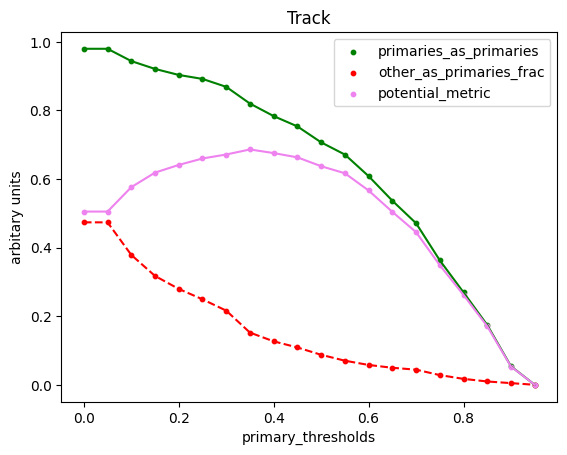

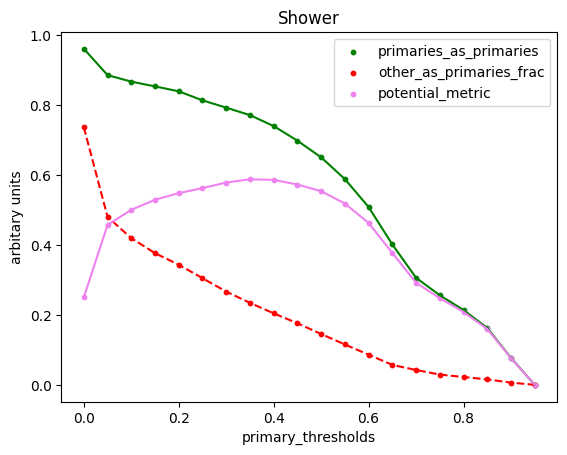

In [7]:
############################
# Draw primary plots!
############################

potential_metric = [np.array(primaries_as_primaries_frac[0]) * np.array(other_as_other_frac[0]), np.array(primaries_as_primaries_frac[1]) * np.array(other_as_other_frac[1])]


for i in [0, 1] :
#     plt.clf()
#     plt.scatter(primary_thresholds, primary_efficiency[i], color='red', label='efficiency', s=10)
#     plt.plot(primary_thresholds, primary_efficiency[i], color='red')
#     plt.scatter(primary_thresholds, primary_purity[i], color='green', label='purity', s=10)
#     plt.plot(primary_thresholds, primary_purity[i], color='green')
#     plt.scatter(primary_thresholds, primary_metric[i], color='violet', label='efficiency*purity', s=10)
#     plt.plot(primary_thresholds, primary_metric[i], color='violet')

#     plt.title('Track' if i == 0 else 'Shower')
#     plt.xlabel('primary_thresholds')
#     plt.ylabel('arbitary units')
#     plt.legend()
#     plt.show()

    ############################

    plt.clf()
    plt.scatter(primary_thresholds, primaries_as_primaries_frac[i], color='green', label='primaries_as_primaries', s=10)
    plt.plot(primary_thresholds, primaries_as_primaries_frac[i], color='green')
    #plt.scatter(primary_thresholds, primaries_as_other_frac[i], color='red', label='primaries_as_other_frac', s=10)
    #plt.plot(primary_thresholds, primaries_as_other_frac[i], color='red')
    #plt.scatter(primary_thresholds, other_as_other_frac[i], color='green', label='other_as_other_frac', s=10)
    #plt.plot(primary_thresholds, other_as_other_frac[i], color='green', linestyle='dashed')
    plt.scatter(primary_thresholds, other_as_primaries_frac[i], color='red', label='other_as_primaries_frac', s=10)
    plt.plot(primary_thresholds, other_as_primaries_frac[i], color='red', linestyle='dashed')


    plt.scatter(primary_thresholds, potential_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(primary_thresholds, potential_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('primary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [8]:
#######################################
# Define optimal primary threshold
#######################################

PRIMARY_THRESHOLD_TRACK = 0.35
PRIMARY_THRESHOLD_SHOWER = 0.45

In [9]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

new_gen = []
new_parentPFPIndex = []

primaries = []


for iEvent in range(nEntries) :

    particle_mask = np.array(particleMask_in[iEvent])
    primary_link_mask = np.array(primaryLinkMask_in[iEvent])
    
    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
    primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]
    nParticles = np.count_nonzero(particle_mask)
    
    this_parentPFPIndex = [BOGUS_INT] * nParticles
    this_gen = [BOGUS_INT] * nParticles
    
    this_primaries = []
    
    for iParticle in range(nParticles) :
        
        if (nSpacepoints[iParticle] == 0) : 
            continue
            
#         if (trueVisibleGeneration[iParticle] == 2) :
#             this_primaries.append(iParticle)
#             this_gen[iParticle] = 2
#             this_parentPFPIndex[iParticle] = -1
                
        
        isTrack = trackShowerScore[iParticle] > 0.5
            
        primaryNetworkArrayIndex = np.where(primaryPFPIndex == iParticle)
        
        if (primaryNetworkArrayIndex[0].shape[0] == 0) :
            continue
        
        if ((isTrack and primaryScores[primaryNetworkArrayIndex[0][0]] > PRIMARY_THRESHOLD_TRACK) or
            ((not isTrack) and primaryScores[primaryNetworkArrayIndex[0][0]] > PRIMARY_THRESHOLD_SHOWER)) :
            this_primaries.append(iParticle)
            this_gen[iParticle] = 2
            this_parentPFPIndex[iParticle] = -1
    
    new_gen.append(this_gen)
    new_parentPFPIndex.append(this_parentPFPIndex)
    primaries.append(this_primaries)

In [10]:
########################################
# Make copies to save...
########################################

new_gen_pass1 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass1 = copy.deepcopy(new_parentPFPIndex)

In [11]:
########################################
# Later tier thresholds
########################################

SECONDARY_THRESHOLD_TRACK = 0.6
SECONDARY_THRESHOLD_SHOWER = 0.75
TERTIARY_THRESHOLD_TRACK = 0.45
TERTIARY_THRESHOLD_TRACK = 0.45
HIGHER_THRESHOLD_TRACK = 0.80
HIGHER_THRESHOLD_TRACK = 0.80

# For cheated
# SECONDARY_THRESHOLD_TRACK = 0.50
# SECONDARY_THRESHOLD_SHOWER = 0.75
# TERTIARY_THRESHOLD_TRACK = 0.40
# TERTIARY_THRESHOLD_TRACK = 0.55
# HIGHER_THRESHOLD_TRACK = 0.80
# HIGHER_THRESHOLD_TRACK = 0.80

In [12]:
############################
# Tune higher tiers
############################

############################
# first assign to best!!!
############################

higher_thresholds = []

# [track, shower]
secondary_correct_parent_frac = [[], []]
secondary_no_parent_frac = [[], []]
secondary_incorrect_parent_frac = [[], []]

tertiary_correct_parent_frac = [[], []]
tertiary_no_parent_frac = [[], []]
tertiary_incorrect_parent_frac = [[], []]

higher_correct_parent_frac = [[], []]
higher_no_parent_frac = [[], []]
higher_incorrect_parent_frac = [[], []]

############################
# Loop through thresholds
############################
for higher_threshold in range(0,20) :
    
    higher_threshold /= float(20)
    #print('---------------------------------------------')
    #print('higher_threshold:', higher_threshold)
    #print('')
    
    higher_thresholds.append(higher_threshold)

    n_secondary = [0, 0]
    secondary_correct_parent = [0, 0]
    secondary_no_parent = [0, 0]
    secondary_incorrect_parent = [0, 0]

    n_tertiary = [0, 0]
    tertiary_correct_parent = [0, 0]
    tertiary_no_parent = [0, 0]
    tertiary_incorrect_parent = [0, 0]
    
    n_higher = [0, 0]
    higher_correct_parent = [0, 0]
    higher_no_parent = [0, 0]
    higher_incorrect_parent = [0, 0]

    ############################
    # Loop through events
    ############################
    
    for iEvent in range(nEntries) :

        this_particle_tiers = [[]]
        this_particle_tiers[0] = primaries[iEvent]

         # we have to make copies as we're going to want to fill these lists with the final result
        this_parentPFPIndex = new_parentPFPIndex[iEvent].copy()
        this_gen = new_gen[iEvent].copy()
        
        # Get data for the event
        particle_mask = np.array(particleMask_in[iEvent])     
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
        
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
        
        parentToChildDict = {}
        
        for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
            parentToChildDict[particlePFPIndex] = []
        
        for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
            if particlePFPIndex in higherTierChildIndex : 
                
                linkIndices = np.where(higherTierChildIndex == particlePFPIndex)[0] 
                
                iFoundParent = -1
                highestLinkScore = -1.0      
                
                for linkIndex in linkIndices :
                    if (higherTierScores[linkIndex] > highestLinkScore) :
                        
                        highestLinkScore = higherTierScores[linkIndex]
                        iFoundParent = higherTierParentIndex[linkIndex]
                
                if (iFoundParent >= 0) :
                    parentToChildDict[iFoundParent].append(particlePFPIndex)

        ############################
        # Build hierarchy
        ############################      
        # Fill each tier at a time
        while (len(this_particle_tiers[-1]) != 0) :
            
            tier = []
            
            # Add in highest?
            for iParent in this_particle_tiers[-1]:
                for iChild in parentToChildDict[iParent] :
                    
                    # If the child has already been assigned a parent
                    if (this_gen[iChild] != BOGUS_INT) :
                        continue
                        
                    linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0]
                        
                    if (len(linkIndex) == 0) :
                        continue
                        
                    linkIndex = linkIndex[0] 
                    isTrack = trackShowerScore[iChild]
                        
                    if (higherTierScores[linkIndex] < higher_threshold) : 
                        continue
                        
                    this_parentPFPIndex[iChild] = iParent
                    this_gen[iChild] = len(this_particle_tiers) + 2
                    tier.append(iChild)

            this_particle_tiers.append(tier)
            
        ############################
        # Turn into numpy arrays
        ############################  
        this_parentPFPIndex = np.array(this_parentPFPIndex)
        this_gen = np.array(this_gen)

        for trackShowerIndex in [0, 1] :
            ignore_mask = np.logical_or(nSpacepoints == 0, trueVisibleGeneration == -999)
            trackShower_mask = (trackShowerScore > 0.5) if trackShowerIndex == 0 else np.logical_not(trackShowerScore > 0.5)

            #########################
            # Get tier masks
            #########################
            true_primary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 2)
            true_secondary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 3)
            true_tertiary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 4)
            true_higher_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), 
                                              np.logical_not(np.logical_or(true_primary_mask, np.logical_or(true_secondary_mask, true_tertiary_mask))))

            ############################
            # Counts
            ############################ 
            # Secondary
            n_secondary[trackShowerIndex] += np.count_nonzero(true_secondary_mask)
            secondary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_secondary_mask] == this_parentPFPIndex[true_secondary_mask], 
                                                                                          this_gen[true_secondary_mask] == 3))
            secondary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_secondary_mask] == BOGUS_INT)            
            secondary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_secondary_mask] == trueVisibleParentPFPIndex[true_secondary_mask], \
                                                                                                         np.logical_or(this_gen[true_secondary_mask] == 2, \
                                                                                                                       this_gen[true_secondary_mask] == BOGUS_INT))))
            # Tertiary
            n_tertiary[trackShowerIndex] += np.count_nonzero(true_tertiary_mask)
            tertiary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_tertiary_mask] == this_parentPFPIndex[true_tertiary_mask], 
                                                                                         this_gen[true_tertiary_mask] == 4))
            tertiary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_tertiary_mask] == BOGUS_INT)
            tertiary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_tertiary_mask] == trueVisibleParentPFPIndex[true_tertiary_mask], \
                                                                                                         np.logical_or(this_gen[true_tertiary_mask] == 2, \
                                                                                                                       this_gen[true_tertiary_mask] == BOGUS_INT))))

            n_higher[trackShowerIndex] += np.count_nonzero(true_higher_mask)
            higher_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentPFPIndex[true_higher_mask] == this_parentPFPIndex[true_higher_mask])
            higher_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_higher_mask] == BOGUS_INT)
            higher_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_higher_mask] == trueVisibleParentPFPIndex[true_higher_mask], \
                                                                                                         np.logical_or(this_gen[true_higher_mask] == 2, \
                                                                                                                       this_gen[true_higher_mask] == BOGUS_INT))))
        
    #####################################
    # Calculate metrics for threshold
    #####################################    
    for trackShowerIndex in [0, 1] :
        
        secondary_correct_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_correct_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_no_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_no_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_incorrect_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_incorrect_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))

        tertiary_correct_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_correct_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_no_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_no_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_incorrect_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_incorrect_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))

        higher_correct_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_correct_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_no_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_no_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_incorrect_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_incorrect_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))

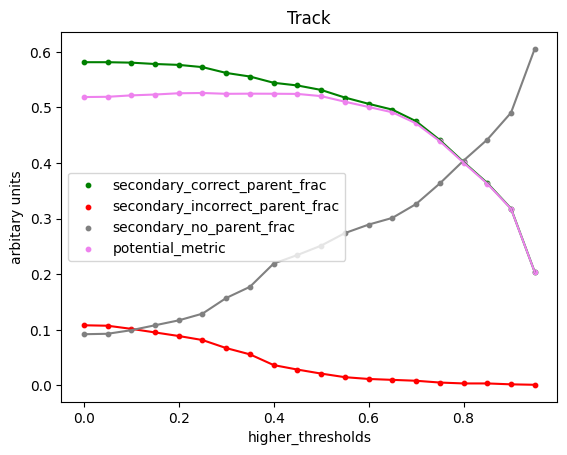

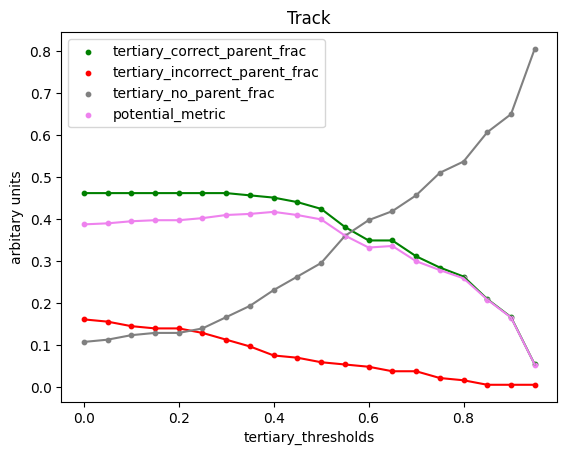

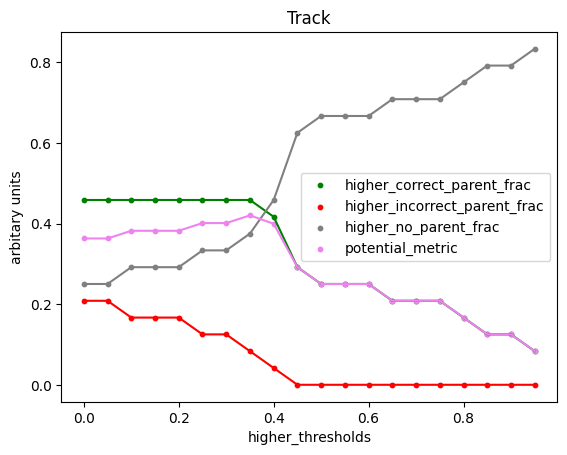

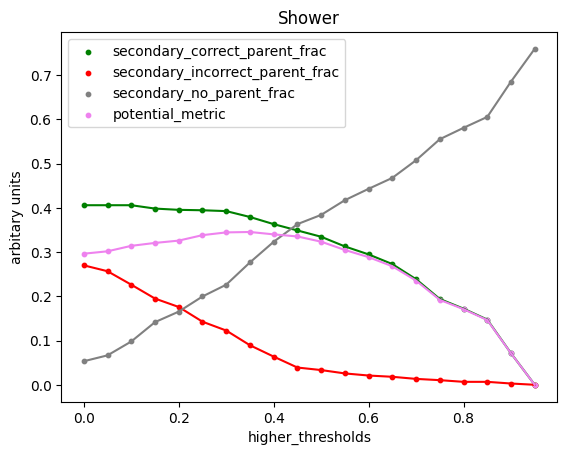

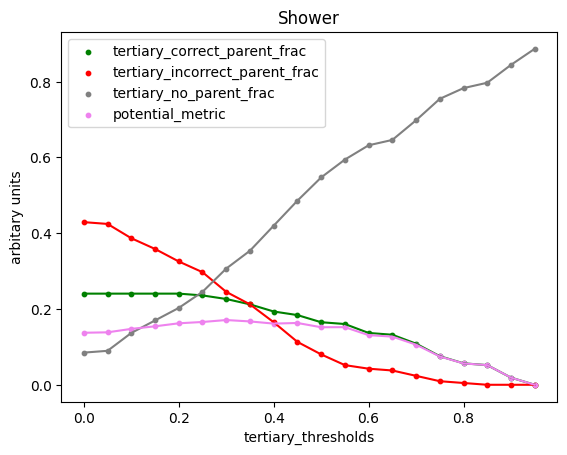

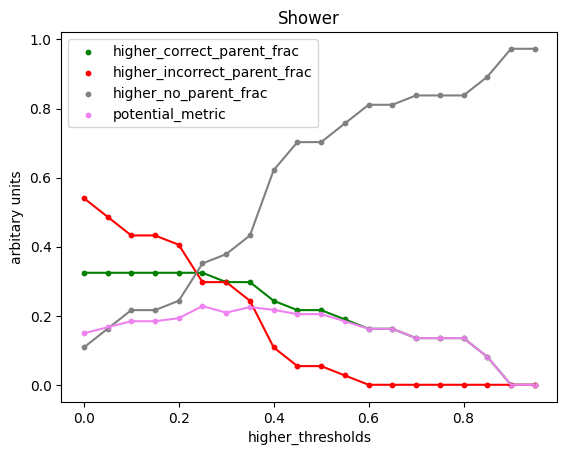

In [13]:
############################
# Draw later tier plots!
############################

potential_secondary_metric = [np.array(secondary_correct_parent_frac[0]) * (1 - np.array(secondary_incorrect_parent_frac[0])), np.array(secondary_correct_parent_frac[1]) * (1 - np.array(secondary_incorrect_parent_frac[1]))]
potential_tertiary_metric = [np.array(tertiary_correct_parent_frac[0]) * (1 - np.array(tertiary_incorrect_parent_frac[0])), np.array(tertiary_correct_parent_frac[1]) * (1 - np.array(tertiary_incorrect_parent_frac[1]))]
potential_higher_metric = [np.array(higher_correct_parent_frac[0]) * (1 - np.array(higher_incorrect_parent_frac[0])), np.array(higher_correct_parent_frac[1]) * (1 - np.array(higher_incorrect_parent_frac[1]))]

############################
# Higher tier plots!
############################
for i in [0, 1] :
    plt.clf()
    plt.scatter(higher_thresholds, secondary_correct_parent_frac[i], color='green', label='secondary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, secondary_incorrect_parent_frac[i], color='red', label='secondary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, secondary_no_parent_frac[i], color='gray', label='secondary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_secondary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_secondary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, tertiary_correct_parent_frac[i], color='green', label='tertiary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red', label='tertiary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, tertiary_no_parent_frac[i], color='gray', label='tertiary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_tertiary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_tertiary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('tertiary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, higher_correct_parent_frac[i], color='green', label='higher_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, higher_incorrect_parent_frac[i], color='red', label='higher_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, higher_no_parent_frac[i], color='gray', label='higher_no_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_higher_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_higher_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [14]:
#######################################
# Define optimal higher threshold
#######################################

SECONDARY_THRESHOLD_TRACK_PASS1 = 0.60
SECONDARY_THRESHOLD_SHOWER_PASS1 = 0.70

HIGHER_THRESHOLD_TRACK_PASS1 = 0.60
HIGHER_THRESHOLD_SHOWER_PASS1 = 0.70

In [15]:
##################################################
# Build the higher tier with optimised threshold!
##################################################

for iEvent in range(nEntries) :

    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]

    # In this case we do not want to make a copy
    this_parentPFPIndex = new_parentPFPIndex[iEvent] 
    this_gen = new_gen[iEvent] 
    
    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])
    higher_link_mask = np.array(higherLinkMask_in[iEvent])

    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueTrackID = np.array(trueTrackID_in[iEvent], dtype='int')[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]

    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
    
    parentToChildDict = {}
        
    for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
        parentToChildDict[particlePFPIndex] = []

    for particlePFPIndex in range(np.count_nonzero(particle_mask)) :
        if particlePFPIndex in higherTierChildIndex : 
            linkIndices = np.where(higherTierChildIndex == particlePFPIndex)[0] 

            iFoundParent = -1
            highestLinkScore = -1.0         

            for linkIndex in linkIndices :
                if (higherTierScores[linkIndex] > highestLinkScore) :

                    highestLinkScore = higherTierScores[linkIndex]
                    iFoundParent = higherTierParentIndex[linkIndex]

            if (iFoundParent >= 0) :
                parentToChildDict[iFoundParent].append(particlePFPIndex)

    ############################
    # Build hierarchy
    ############################    
    # Fill each tier at a time
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Loop over particles in last built tier
        for iParent in this_particle_tiers[-1]:
            for iChild in parentToChildDict[iParent] :

                # If the child has already been assigned a parent
                if (this_gen[iChild] != BOGUS_INT) :
                    continue

                linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0][0] 
                
                isTrack = trackShowerScore[iChild]
                    
                 # Secondary
                if ((len(this_particle_tiers) == 1) and isTrack and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_TRACK_PASS1)) :
                    continue
                
                if ((len(this_particle_tiers) == 1) and (not isTrack) and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_SHOWER_PASS1)) :
                    continue

                # Higher
                if ((len(this_particle_tiers) != 1) and (isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_TRACK_PASS1)) : 
                    continue

                if ((len(this_particle_tiers) != 1) and (not isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_SHOWER_PASS1)) : 
                    continue

                this_parentPFPIndex[iChild] = iParent
                this_gen[iChild] = len(this_particle_tiers) + 2
                tier.append(iChild)

        # Tier complete, add into hierarchy
        this_particle_tiers.append(tier)


In [16]:
########################################
# Make copies to save...
########################################

new_gen_pass2 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass2 = copy.deepcopy(new_parentPFPIndex)

In [17]:
############################
# Tune higher tiers
############################

############################
# second assign the rest!!!
############################

higher_thresholds = []

# [track, shower]
secondary_correct_parent_frac = [[], []]
secondary_no_parent_frac = [[], []]
secondary_incorrect_parent_frac = [[], []]

tertiary_correct_parent_frac = [[], []]
tertiary_no_parent_frac = [[], []]
tertiary_incorrect_parent_frac = [[], []]

higher_correct_parent_frac = [[], []]
higher_no_parent_frac = [[], []]
higher_incorrect_parent_frac = [[], []]

############################
# Loop through thresholds
############################
for higher_threshold in range(0,20) :
    
    higher_threshold /= float(20)
    #print('---------------------------------------------')
    #print('higher_threshold:', higher_threshold)
    #print('')
    
    higher_thresholds.append(higher_threshold)

    n_secondary = [0, 0]
    secondary_correct_parent = [0, 0]
    secondary_no_parent = [0, 0]
    secondary_incorrect_parent = [0, 0]

    n_tertiary = [0, 0]
    tertiary_correct_parent = [0, 0]
    tertiary_no_parent = [0, 0]
    tertiary_incorrect_parent = [0, 0]
    
    n_higher = [0, 0]
    higher_correct_parent = [0, 0]
    higher_no_parent = [0, 0]
    higher_incorrect_parent = [0, 0]

    ############################
    # Loop through events
    ############################
    
    for iEvent in range(nEntries) :

        this_particle_tiers = [[]]
        this_particle_tiers[0] = primaries[iEvent]

         # we have to make copies as we're going to want to fill these lists with the final result
        this_parentPFPIndex = new_parentPFPIndex[iEvent].copy()
        this_gen = new_gen[iEvent].copy()
        
        # Get data for the event
        particle_mask = np.array(particleMask_in[iEvent])     
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        
        nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
        trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
        trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
        trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
        
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]

        ############################
        # Build hierarchy
        ############################      
        # Fill each tier at a time
        while (len(this_particle_tiers[-1]) != 0) :
            
            tier = []
                    
            # Loop over particles in last built tier
            for iParent in this_particle_tiers[-1]:
                for iChild in range(np.count_nonzero(particle_mask)) : #parentToChildDict[iParent] :
                    
                    # If the child has already been assigned a parent
                    if (this_gen[iChild] != BOGUS_INT) :
                        # We need to put in the ones already built.. 
                        if (len(np.where(this_particle_tiers[-1] == this_parentPFPIndex[iChild])[0]) != 0) :
                            tier.append(iChild)
                        continue
                        
                    linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0]
                        
                    if (len(linkIndex) == 0) :
                        continue
                        
                    linkIndex = linkIndex[0] 
                    isTrack = trackShowerScore[iChild]
                    
#                     # Secondary
#                     if ((len(this_particle_tiers) == 1) and (isTrack and higherTierScores[linkIndex] < SECONDARY_THRESHOLD_TRACK)) :
#                         continue
                    
#                     if ((len(this_particle_tiers) == 1) and (not isTrack and higherTierScores[linkIndex] < SECONDARY_THRESHOLD_SHOWER)) :
#                         continue
                        
#                     # Tertiary
#                     if ((len(this_particle_tiers) == 2) and (isTrack and higherTierScores[linkIndex] < TERTIARY_THRESHOLD_TRACK)) :
#                         continue
                    
#                     if ((len(this_particle_tiers) == 2) and (not isTrack and higherTierScores[linkIndex] < TERTIARY_THRESHOLD_SHOWER)) :
#                         continue
                    
#                     if ((len(this_particle_tiers) != 1 and len(this_particle_tiers) != 2) and (higherTierScores[linkIndex] < higher_threshold)) : 
#                         continue
                        
                    if ((higherTierScores[linkIndex] < higher_threshold)) : 
                        continue
                    
                    this_parentPFPIndex[iChild] = iParent
                    this_gen[iChild] = len(this_particle_tiers) + 2
                    tier.append(iChild)


            this_particle_tiers.append(tier)
            
        ############################
        # Turn into numpy arrays
        ############################  
        this_parentPFPIndex = np.array(this_parentPFPIndex)
        this_gen = np.array(this_gen)

        for trackShowerIndex in [0, 1] :
            ignore_mask = np.logical_or(nSpacepoints == 0, trueVisibleGeneration == -999)
            trackShower_mask = (trackShowerScore > 0.5) if trackShowerIndex == 0 else np.logical_not(trackShowerScore > 0.5)

            #########################
            # Get tier masks
            #########################
            true_primary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 2)
            true_secondary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 3)
            true_tertiary_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), trueVisibleGeneration == 4)
            true_higher_mask = np.logical_and(np.logical_and(np.logical_not(ignore_mask), trackShower_mask), 
                                              np.logical_not(np.logical_or(true_primary_mask, np.logical_or(true_secondary_mask, true_tertiary_mask))))

            ############################
            # Counts
            ############################ 
            # Secondary
            n_secondary[trackShowerIndex] += np.count_nonzero(true_secondary_mask)
            secondary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_secondary_mask] == this_parentPFPIndex[true_secondary_mask], 
                                                                                          this_gen[true_secondary_mask] == 3))
            secondary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_secondary_mask] == BOGUS_INT)            
            secondary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_secondary_mask] == trueVisibleParentPFPIndex[true_secondary_mask], \
                                                                                                         np.logical_or(this_gen[true_secondary_mask] == 2, \
                                                                                                                       this_gen[true_secondary_mask] == BOGUS_INT))))
            # Tertiary
            n_tertiary[trackShowerIndex] += np.count_nonzero(true_tertiary_mask)
            tertiary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentPFPIndex[true_tertiary_mask] == this_parentPFPIndex[true_tertiary_mask], 
                                                                                         this_gen[true_tertiary_mask] == 4))
            tertiary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_tertiary_mask] == BOGUS_INT)
            tertiary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_tertiary_mask] == trueVisibleParentPFPIndex[true_tertiary_mask], \
                                                                                                         np.logical_or(this_gen[true_tertiary_mask] == 2, \
                                                                                                                       this_gen[true_tertiary_mask] == BOGUS_INT))))

            n_higher[trackShowerIndex] += np.count_nonzero(true_higher_mask)
            higher_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentPFPIndex[true_higher_mask] == this_parentPFPIndex[true_higher_mask])
            higher_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_higher_mask] == BOGUS_INT)
            higher_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(this_parentPFPIndex[true_higher_mask] == trueVisibleParentPFPIndex[true_higher_mask], \
                                                                                                         np.logical_or(this_gen[true_higher_mask] == 2, \
                                                                                                                       this_gen[true_higher_mask] == BOGUS_INT))))
        
    #####################################
    # Calculate metrics for threshold
    #####################################    
    for trackShowerIndex in [0, 1] :
        
        secondary_correct_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_correct_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_no_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_no_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_incorrect_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_incorrect_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))

        tertiary_correct_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_correct_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_no_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_no_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_incorrect_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_incorrect_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))

        higher_correct_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_correct_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_no_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_no_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_incorrect_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_incorrect_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))

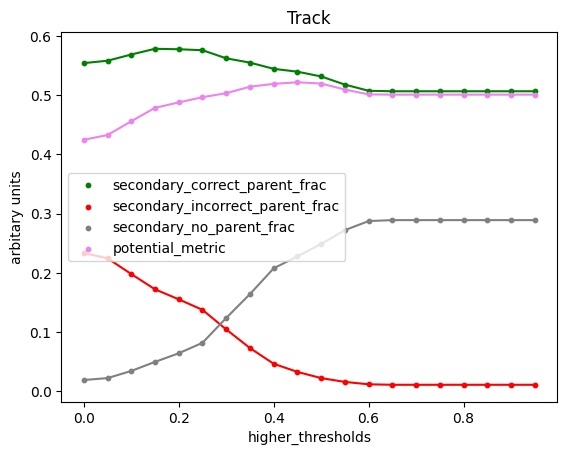

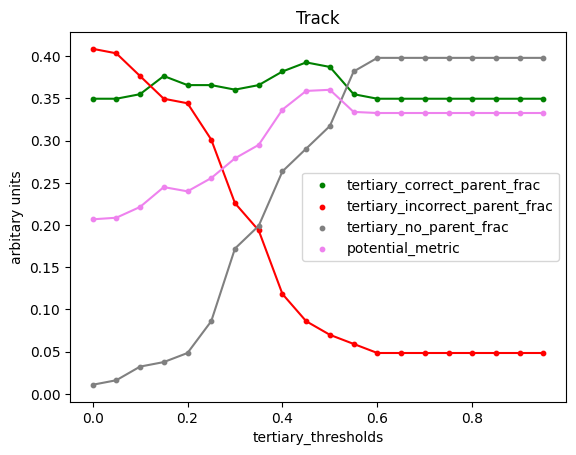

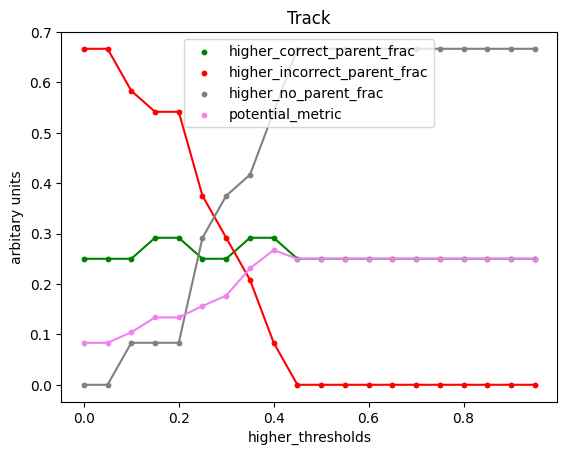

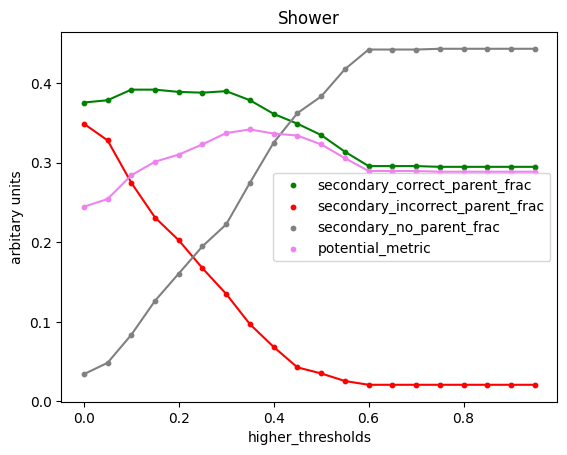

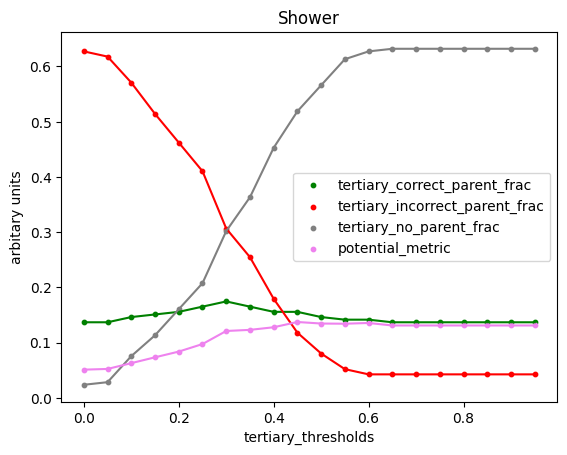

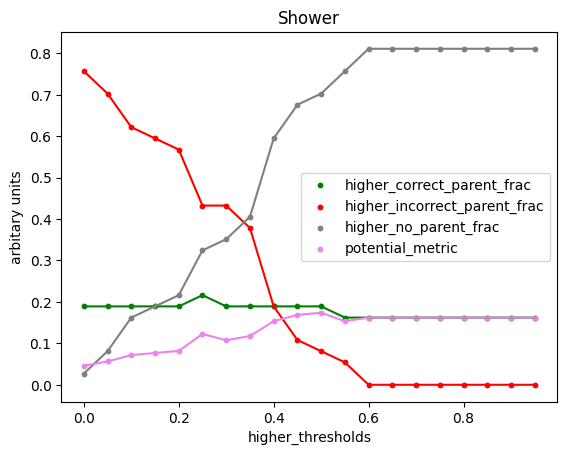

In [18]:
############################
# Draw later tier plots!
############################

potential_secondary_metric = [np.array(secondary_correct_parent_frac[0]) * (1 - np.array(secondary_incorrect_parent_frac[0])), np.array(secondary_correct_parent_frac[1]) * (1 - np.array(secondary_incorrect_parent_frac[1]))]
potential_tertiary_metric = [np.array(tertiary_correct_parent_frac[0]) * (1 - np.array(tertiary_incorrect_parent_frac[0])), np.array(tertiary_correct_parent_frac[1]) * (1 - np.array(tertiary_incorrect_parent_frac[1]))]
potential_higher_metric = [np.array(higher_correct_parent_frac[0]) * (1 - np.array(higher_incorrect_parent_frac[0])), np.array(higher_correct_parent_frac[1]) * (1 - np.array(higher_incorrect_parent_frac[1]))]

############################
# Higher tier plots!
############################
for i in [0, 1] :
    plt.clf()
    plt.scatter(higher_thresholds, secondary_correct_parent_frac[i], color='green', label='secondary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, secondary_incorrect_parent_frac[i], color='red', label='secondary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, secondary_no_parent_frac[i], color='gray', label='secondary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_secondary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_secondary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, tertiary_correct_parent_frac[i], color='green', label='tertiary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red', label='tertiary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, tertiary_no_parent_frac[i], color='gray', label='tertiary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_tertiary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_tertiary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('tertiary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, higher_correct_parent_frac[i], color='green', label='higher_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, higher_incorrect_parent_frac[i], color='red', label='higher_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, higher_no_parent_frac[i], color='gray', label='higher_no_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_higher_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_higher_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [19]:
#             # Loop over particles in last built tier
#             for iParent in this_particle_tiers[-1]:
#                 for iChild in range(np.count_nonzero(particle_mask)) : #parentToChildDict[iParent] :
                    
#                     # If the child has already been assigned a parent
#                     if (this_gen[iChild] != BOGUS_INT) :
#                         continue
                        
#                     linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0]
                        
#                     if (len(linkIndex) == 0) :
#                         continue
                        
#                     linkIndex = linkIndex[0] 
#                     isTrack = trackShowerScore[iChild]
                    
# #                     # Secondary
# #                     if ((len(this_particle_tiers) == 1) and (isTrack and higherTierScores[linkIndex] < SECONDARY_THRESHOLD_TRACK)) :
# #                         continue
                    
# #                     if ((len(this_particle_tiers) == 1) and (not isTrack and higherTierScores[linkIndex] < SECONDARY_THRESHOLD_SHOWER)) :
# #                         continue
                        
# #                     # Tertiary
# #                     if ((len(this_particle_tiers) == 2) and (isTrack and higherTierScores[linkIndex] < TERTIARY_THRESHOLD_TRACK)) :
# #                         continue
                    
# #                     if ((len(this_particle_tiers) == 2) and (not isTrack and higherTierScores[linkIndex] < TERTIARY_THRESHOLD_SHOWER)) :
# #                         continue
                    
# #                     if ((len(this_particle_tiers) != 1 and len(this_particle_tiers) != 2) and (higherTierScores[linkIndex] < higher_threshold)) : 
# #                         continue
                        
#                     if ((higherTierScores[linkIndex] < higher_threshold)) : 
#                         continue
                    
#                     this_parentPFPIndex[iChild] = iParent
#                     this_gen[iChild] = len(this_particle_tiers) + 2
#                     tier.append(iChild)

            # Tier complete, add into hierarchy
            #print('tier:', tier)

In [20]:
#######################################
# Define optimal higher threshold
#######################################

SECONDARY_THRESHOLD_TRACK_PASS2 = 0.40
SECONDARY_THRESHOLD_SHOWER_PASS2 = 0.40

HIGHER_THRESHOLD_TRACK_PASS2 = 0.40
HIGHER_THRESHOLD_SHOWER_PASS2 = 0.40

In [21]:
##################################################
# Build the higher tier with optimised threshold!
##################################################

for iEvent in range(nEntries) :

    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]

    # In this case we do not want to make a copy
    this_parentPFPIndex = new_parentPFPIndex[iEvent] 
    this_gen = new_gen[iEvent] 
    
    # Get data for the event
    particle_mask = np.array(particleMask_in[iEvent])
    higher_link_mask = np.array(higherLinkMask_in[iEvent])

    nSpacepoints = np.array(nSpacepoints_in[iEvent], dtype='int')[particle_mask]
    trackShowerScore = np.array(trackShowerScore_in[iEvent])[particle_mask]
    trueTrackID = np.array(trueTrackID_in[iEvent], dtype='int')[particle_mask]
    trueVisibleGeneration = np.array(trueVisibleGeneration_in[iEvent], dtype='int')[particle_mask]
    trueVisibleParentPFPIndex = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]

    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]

    ############################
    # Build hierarchy
    ############################    
    # Fill each tier at a time
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Loop over particles in last built tier
        for iParent in this_particle_tiers[-1]:
            for iChild in range(np.count_nonzero(particle_mask)) : 

                # If the child has already been assigned a parent
                if (this_gen[iChild] != BOGUS_INT) :
                    # We need to put in the ones already built.. 
                    if (len(np.where(this_particle_tiers[-1] == this_parentPFPIndex[iChild])[0]) != 0) :
                        tier.append(iChild)
                    continue

                linkIndex = np.where(np.logical_and(higherTierChildIndex == iChild, higherTierParentIndex == iParent))[0]

                if (len(linkIndex) == 0) :
                    continue

                linkIndex = linkIndex[0] 
                
                isTrack = trackShowerScore[iChild]
                    
                 # Secondary
                if ((len(this_particle_tiers) == 1) and isTrack and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_TRACK_PASS2)) :
                    continue
                
                if ((len(this_particle_tiers) == 1) and (not isTrack) and (higherTierScores[linkIndex] < SECONDARY_THRESHOLD_SHOWER_PASS2)) :
                    continue

                # Higher
                if ((len(this_particle_tiers) != 1) and (isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_TRACK_PASS2)) : 
                    continue

                if ((len(this_particle_tiers) != 1) and (not isTrack) and (higherTierScores[linkIndex] < HIGHER_THRESHOLD_SHOWER_PASS2)) : 
                    continue

                this_parentPFPIndex[iChild] = iParent
                this_gen[iChild] = len(this_particle_tiers) + 2
                tier.append(iChild)

        # Tier complete, add into hierarchy
        this_particle_tiers.append(tier)


In [22]:
########################################
# Make copies to save...
########################################

new_gen_pass3 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass3 = copy.deepcopy(new_parentPFPIndex)

In [32]:
for iEvent in range(nEntries) : 

        # if target event?
#         if (isNC_in[iEvent] == 1) :
#             continue            
            
#         if (nuPDG_in[iEvent] != 14) :
#             continue
            
        # Particle mask
        particle_mask = np.array(particleMask_in[iEvent])
        # PFP info
        nSpacepoints_np = np.array(nSpacepoints_in[iEvent])[particle_mask]
        # Truth
        trueGeneration_np = np.array(trueGeneration_in[iEvent])[particle_mask]
        trueParentPDG_np = np.array(trueParentPDG_in[iEvent])[particle_mask]
        trueVisibleGeneration_np = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
        trueVisibleParentPFPIndex_np = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
        pfpTruePDG_np = np.array(pfpTruePDG_in[iEvent])[particle_mask]
        trueTrackID_np = np.array(trueTrackID_in[iEvent])[particle_mask]
        # New
        newGen_np = np.array(new_gen[iEvent])
        newParentPFPIndex_np = np.array(new_parentPFPIndex[iEvent])
        # Pandora
        pandoraGeneration_np = np.array(pandoraGeneration_in[iEvent])[particle_mask]        
        ##########################
        # Higher stuff
        ##########################
        higher_link_mask = np.array(higherLinkMask_in[iEvent])
        higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
        trainingCutL = np.array(trainingCutL_in[iEvent])[higher_link_mask]
        trainingCutT = np.array(trainingCutT_in[iEvent])[higher_link_mask]

        ignore_mask = np.logical_or(nSpacepoints_np == 0, trueVisibleGeneration_np == -999)
        target_mask = np.logical_and(np.logical_not(ignore_mask), np.logical_and(np.logical_and(trueVisibleGeneration_np == 3, (trueVisibleParentPFPIndex_np == newParentPFPIndex_np)), pandoraGeneration_np != 3))
        
        for iParticle in range(np.count_nonzero(particle_mask)) :
            if (target_mask[iParticle]) :
                
                linkIndex = np.where(np.logical_and(higherTierChildIndex == iParticle, higherTierParentIndex == trueVisibleParentPFPIndex_np[iParticle]))[0]
                
                if (linkIndex.shape[0] != 0) :
#                     if ((abs(trainingCutL[linkIndex[0]]) < 10.0) and (trainingCutT[linkIndex[0]] < 10.0)) :
                    print(iEvent)

4
4
15
15
17
30
37
37
38
42
43
44
47
47
47
47
62
64
74
76
82
82
83
86
86
94
99
110
110
112
112
122
122
122
122
122
122
123
133
135
142
143
143
143
152
152
152
153
157
158
163
164
164
175
175
182
190
195
195
198
202
202
202
205
224
224
234
234
240
240
245
250
251
255
258
258
266
272
285
293
294
294
294
294
294
297
297
302
305
336
352
353
354
354
360
360
360
368
368
383
384
384
388
395
406
421
421
426
428
442
447
447
451
451
452
454
457
458
460
460
460
469
469
469
469
469
476
478
511
516
521
521
529
538
538
545
551
551
551
553
553
553
553
554
554
558
568
568
568
568
568
568
568
568
568
572
572
572
573
573
573
583
583
590
590
590
605
608
627
627
627
634
635
639
642
643
664
668
668
669
669
676
678
694
694
694
705
705
706
708
708
716
729
729
741
747
750
750
758
758
759
765
776
781
781
784
786
787
798
818
822
840
846
847
847
852
872
877
877
880
880
880
880
903
906
914
914
914
914
919
919
930
930
942
949
955
957
958
958
973
977
977
984
988
990
999
1009
1012
1013
1022
1026
1029
1032
1039
1045


In [40]:
for iEvent in [1944] : 

    ##########################
    # Node stuff
    ##########################
    # Particle mask
    particle_mask = np.array(particleMask_in[iEvent])
    # PFP info
    nSpacepoints_np = np.array(nSpacepoints_in[iEvent])[particle_mask]
    # Truth
    trueVisibleGeneration_np = np.array(trueVisibleGeneration_in[iEvent])[particle_mask]
    trueVisibleParentPDG_np = np.array(trueVisibleParentPDG_in[iEvent])[particle_mask]
    trueParentPDG_np = np.array(trueParentPDG_in[iEvent])[particle_mask]
    pfpTruePDG_np = np.array(pfpTruePDG_in[iEvent])[particle_mask]
    trueTrackID_np = np.array(trueTrackID_in[iEvent])[particle_mask]
    trueVisibleParentPFPIndex_np = np.array(trueVisibleParentPFPIndex_in[iEvent], dtype='int')[particle_mask]
    pfpIndex_np = np.array(range(0, np.count_nonzero(particle_mask)))
    ignore_mask = np.logical_or(nSpacepoints_np == 0, trueVisibleGeneration_np == -999)
    # New
    newGen_np = np.array(new_gen[iEvent])
    newParentPFPIndex_np = np.array(new_parentPFPIndex[iEvent])
    # Pandora
    pandoraGeneration_np = np.array(pandoraGeneration_in[iEvent])[particle_mask]
    pandoraParentSelf_np = np.array(pandoraParentSelf_in[iEvent])[particle_mask]
    trueVisibleParentSelf_np = np.array(trueVisibleParentSelf_in[iEvent])[particle_mask]
    
    ##########################
    # Primary stuff
    ##########################
    primary_link_mask = np.array(primaryLinkMask_in[iEvent])
    primaryPFPIndex = np.array(primaryPFPIndex_in[iEvent], dtype='int')[primary_link_mask]
    primaryScores = np.array(primaryTotNetworkPred_in[iEvent])[primary_link_mask]
    trainingDCA = np.array(trainingDCA_in[iEvent])[primary_link_mask]
    
    ##########################
    # Higher stuff
    ##########################
    higher_link_mask = np.array(higherLinkMask_in[iEvent])
    higherTierChildIndex = np.array(childPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierParentIndex = np.array(parentPFPIndex_in[iEvent], dtype='int')[higher_link_mask]
    higherTierScores = np.array(higherTotNetworkPred_in[iEvent])[higher_link_mask]
    trainingCutSep = np.array(trainingCutSep_in[iEvent])[higher_link_mask]
    trainingCutL = np.array(trainingCutL_in[iEvent])[higher_link_mask]
    trainingCutT = np.array(trainingCutT_in[iEvent])[higher_link_mask]

    print('-------')
    print('EVENT')
    print('-------')
    print('run:', run_in[iEvent])
    print('subrun:', subrun_in[iEvent])
    print('event:', event_in[iEvent])
    print('pfpIndex: ', pfpIndex_np)
    print('new_gen                 :', newGen_np)
    print('pandoraGeneration_np    :', pandoraGeneration_np)
    print('trueVisibleGeneration_np:', trueVisibleGeneration_np)
    print('')
    print('newParentPFPIndex_np:', newParentPFPIndex_np)
    
    print('trueVisibleParentPFPIndex_np:', trueVisibleParentPFPIndex_np)
    print('----------')
    
    
    for i in range(pandoraGeneration_np.shape[0]) : 
        print('i:     ', i)
        print('me     :', newGen_np[i])
        print('pandora:', pandoraGeneration_np[i])
        print('truth  :', trueVisibleGeneration_np[i])
        
        print('my parent:', newParentPFPIndex_np[i])
        print('true parent:', trueVisibleParentPFPIndex_np[i])
        print('this PDG:', pfpTruePDG_np[i])
        print('visible parent PDG:', trueVisibleParentPDG_np[i])
        print('generator parent PDG:', trueParentPDG_np[i])
    
        primaryLinkIndex = np.where(primaryPFPIndex == i)[0]
        if (primaryLinkIndex.shape[0] != 0) : 
            print('primaryScores: ', primaryScores[primaryLinkIndex[0]])
            print('trainingDCA: ', trainingDCA[primaryLinkIndex[0]])
        
        print('---')
    
        invLinkIndex_true = np.where(np.logical_and(higherTierChildIndex == i, higherTierParentIndex == trueVisibleParentPFPIndex_np[i]))[0]
        if (invLinkIndex_true.shape[0] != 0) :
            print('trainingCutSep true:', trainingCutSep[invLinkIndex_true[0]])
            print('trainingCutL true:', trainingCutL[invLinkIndex_true[0]])
            print('trainingCutT true:', trainingCutT[invLinkIndex_true[0]])
            print('higherTierScores true:', higherTierScores[invLinkIndex_true[0]])

        print('---')
            
        invLinkIndex_me = np.where(np.logical_and(higherTierChildIndex == i, higherTierParentIndex == newParentPFPIndex_np[i]))[0]
        if (invLinkIndex_me.shape[0] != 0) :
            print('trainingCutSep me:', trainingCutSep[invLinkIndex_me[0]])
            print('trainingCutL me:', trainingCutL[invLinkIndex_me[0]])
            print('trainingCutT me:', trainingCutT[invLinkIndex_me[0]])
            print('higherTierScores me:', higherTierScores[invLinkIndex_me[0]])
            
        print('----------')

-------
EVENT
-------
run: 1110
subrun: 1
event: 45371
pfpIndex:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
new_gen                 : [   2    3    2    2    3    2    3 -999 -999    3    3 -999    4]
pandoraGeneration_np    : [2 3 2 2 3 2 3 2 2 2 2 2 4]
trueVisibleGeneration_np: [2 3 2 2 3 2 3 3 3 3 3 4 4]

newParentPFPIndex_np: [  -1    0   -1   -1    2   -1    0 -999 -999    2    2 -999    4]
trueVisibleParentPFPIndex_np: [-1  0 -1 -1  2 -1  0  0  2  2  2  7  4]
----------
i:      0
me     : 2
pandora: 2
truth  : 2
my parent: -1
true parent: -1
this PDG: 2212
visible parent PDG: -1
generator parent PDG: -1
primaryScores:  0.7522225975990295
trainingDCA:  0.30273752081986155
---
---
----------
i:      1
me     : 3
pandora: 3
truth  : 3
my parent: 0
true parent: 0
this PDG: 22
visible parent PDG: 2212
generator parent PDG: 111
primaryScores:  5.028935265727341e-05
trainingDCA:  195.35098888089664
---
trainingCutSep true: 0.7556966864435353
trainingCutL true: -0.273431178073964
training

In [39]:
######################################
# Say that any remaining are primaries
###################################### 

for iEvent in range(nEntries) : 

    this_parentPFPIndex= new_parentPFPIndex[iEvent] # Will not make a copy (will be by reference)
    this_gen = new_gen[iEvent] # Will not make a copy (will be by reference)
    
    for iParticle in range(len(this_gen)) :
            
        if (this_gen[iParticle] == BOGUS_INT) :
            this_parentPFPIndex[iParticle] = -1
            this_gen[iParticle] = 2


In [ ]:
########################################
# Make copies to save...
########################################

new_gen_pass4 = copy.deepcopy(new_gen)
new_parentPFPIndex_pass4 = copy.deepcopy(new_parentPFPIndex)

In [34]:
########################################
# Pandora hierarchy metrics
########################################

Metrics.calculateMetrics_pandora(nEntries, particleMask_in, nSpacepoints_in, trackShowerScore_in, trueVisibleGeneration_in, trueVisibleParentSelf_in, pandoraParentSelf_in, pandoraGeneration_in)

-------------------------------------------------------------
PANDORA
-------------------------------------------------------------
NEW - True Gen    | Primary | Secondary | Tertiary | Higher |
-------------------------------------------------------------
Correct parent CT |0.99     |0.37       |0.24      |0.0     |
Correct parent WT |0.0      |0.38       |0.07      |0.29    |
False primary     |0.0      |0.61       |0.67      |0.67    |
Incorrect parent  |0.01     |0.01       |0.01      |0.04    |
Not tagged        |0.0      |0.0        |0.0       |0.0     |
-------------------------------------------------------------
Total             |4311     |1182       |209       |24      |
n_two_d (not included in metrics): 3
-------------------------------------------------------------

-------------------------------------------------------------
SHOWER
-------------------------------------------------------------
NEW - True Gen    | Primary | Secondary | Tertiary | Higher |
-----------------

In [ ]:
########################################
# Need to pad them so can save them
########################################

# Get target length to match input padded vectors
target_particle_length = particleMask_in.shape[1]

# Pad 
new_gen_pass1 = Padding.process_array(new_gen_pass1, target_particle_length)
new_parentPFPIndex_pass1 = Padding.process_array(new_parentPFPIndex_pass1, target_particle_length)

new_gen_pass2 = Padding.process_array(new_gen_pass2, target_particle_length)
new_parentPFPIndex_pass2 = Padding.process_array(new_parentPFPIndex_pass2, target_particle_length)

new_gen_pass3 = Padding.process_array(new_gen_pass3, target_particle_length)
new_parentPFPIndex_pass3 = Padding.process_array(new_parentPFPIndex_pass3, target_particle_length)

new_gen_pass4 = Padding.process_array(new_gen_pass4, target_particle_length)
new_parentPFPIndex_pass4 = Padding.process_array(new_parentPFPIndex_pass4, target_particle_length)


In [ ]:
########################################
# Save
########################################

file = 'newHierarchy_0_oneModel_JAM'
outputFile = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/' + file + '.npz'
    
np.savez(outputFile, \
         event = event_in, \
         subrun = subrun_in, \
         run = run_in, \
         isNC = isNC_in,
         nuPDG = nuPDG_in,
         particleMask = particleMask_in, \
         pfpTruePDG = pfpTruePDG_in, \
         trueVisibleGeneration = trueVisibleGeneration_in, \
         trueVisibleParentPFPIndex = trueVisibleParentPFPIndex_in, \
         nSpacepoints = nSpacepoints_in, \
         trackShowerScore = trackShowerScore_in, \
         higherLinkMask = higherLinkMask_in, \
         parentPFPIndex = parentPFPIndex_in, \
         childPFPIndex = childPFPIndex_in, \
         trainingCutL = trainingCutL_in, \
         trainingCutT = trainingCutT_in, \
         new_gen_pass1 = new_gen_pass1, \
         new_parentPFPIndex_pass1 = new_parentPFPIndex_pass1, \
         new_gen_pass2 = new_gen_pass2, \
         new_parentPFPIndex_pass2 = new_parentPFPIndex_pass2, \
         new_gen_pass3 = new_gen_pass3, \
         new_parentPFPIndex_pass3 = new_parentPFPIndex_pass3, \
         new_gen_pass4 = new_gen_pass4, \
         new_parentPFPIndex_pass4 = new_parentPFPIndex_pass4)